In [2]:
import pandas as pd
import numpy as np

In [4]:
for type_ in ["f2","f4"]:
    print(np.finfo(type_))
for type_ in ["i1","i2","i4"]:
    print(np.iinfo(type_))

Machine parameters for float16
---------------------------------------------------------------
precision =   3   resolution = 1.00040e-03
machep =    -10   eps =        9.76562e-04
negep =     -11   epsneg =     4.88281e-04
minexp =    -14   tiny =       6.10352e-05
maxexp =     16   max =        6.55040e+04
nexp =        5   min =        -max
---------------------------------------------------------------

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
-------------------------------------------------------

In [5]:
buildings = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz")
weather = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz")
energy = pd.read_csv("http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz")

In [6]:
buildings.memory_usage().sum() / 1024 ** 2

0.0664520263671875

In [7]:
weather.memory_usage().sum() / 1024 ** 2

9.597572326660156

In [8]:
energy.memory_usage().sum() / 1024 ** 2

368.06988525390625

# Оптимизация памяти

In [9]:
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if str(col_type)[:5] == 'float':
            c_min,c_max = df[col].min(),df[col].max()
            if c_min > np.finfo("f2").min and c_max < np.finfo("f2").max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo("f4").min and c_max < np.finfo("f4").max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
        elif str(col_type)[:3] == 'int':
            c_min,c_max = df[col].min(),df[col].max()
            if c_min > np.iinfo("i1").min and c_max < np.iinfo("i1").max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo("i2").min and c_max < np.iinfo("i2").max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo("i4").min and c_max < np.iinfo("i4").max:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
        elif col == 'timestamp':
            df[col] = pd.to_datetime(df[col])
        elif str(col_type)[:8] != 'datetime':
            df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Старт: ",start_mem)
    print("После обработки: ",end_mem)
    return df

In [12]:
buildings = reduce_memory_usage(buildings)
buildings.info()

Старт:  0.017436981201171875
После обработки:  0.017436981201171875
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   site_id      1449 non-null   int8    
 1   building_id  1449 non-null   int16   
 2   primary_use  1449 non-null   category
 3   square_feet  1449 non-null   int32   
 4   year_built   675 non-null    float16 
 5   floor_count  355 non-null    float16 
dtypes: category(1), float16(2), int16(1), int32(1), int8(1)
memory usage: 17.9 KB


In [11]:
weather = reduce_memory_usage(weather)

Старт:  9.597572326660156
После обработки:  3.065974235534668


In [13]:
energy = reduce_memory_usage(energy)

Старт:  368.06988525390625
После обработки:  172.53282356262207


In [14]:
print(buildings.columns,'\n',weather.columns,'\n',energy.columns)

Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object') 
 Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object') 
 Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')


In [15]:
energy = pd.merge(left=energy,right=buildings,how='left',left_on='building_id',right_on='building_id')

In [17]:
energy = pd.merge(left=energy.set_index(['site_id','timestamp']),
                  right=weather.set_index(['site_id','timestamp']),
                                          how='left',left_index=True,right_index=True)

In [22]:
energy = energy.reset_index()

In [23]:
energy.head()

,site_id,timestamp,building_id,meter,meter_reading,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01,0,0,0.0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,0,2016-01-01,1,0,0.0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,0,2016-01-01,2,0,0.0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,0,2016-01-01,3,0,0.0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,0,2016-01-01,4,0,0.0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [25]:
energy = energy.drop(['site_id','meter'],axis=1)

In [27]:
print(sorted(energy['wind_speed'].unique()))

[0.0, 0.5, 1.0, 1.3, 1.5, 1.6, 2.0, 2.1, 2.2, 2.6, 3.0, 3.1, 3.2, 3.6, 4.0, 4.1, 4.6, 5.0, 5.1, 5.7, 6.0, 6.1, 6.2, 6.7, 7.0, 7.2, 7.7, 8.0, 8.2, 8.7, 8.8, 9.0, 9.3, 9.8, 10.0, 10.3, 10.8, 11.0, 11.3, 11.8, 12.0, 12.4, 12.8, 12.9, 13.0, 13.4, 13.9, 14.0, 14.4, 14.9, 15.0, 15.4, 16.5, nan, 16.0, 17.0, 18.0, 18.5, 19.0]


In [28]:
print(sorted(energy['cloud_coverage'].unique()))

[6.0, nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0]


In [29]:
print(sorted(energy['precip_depth_1_hr'].unique()))

[nan, -1.0, 0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 45.0, 46.0, 47.0, 48.0, 50.0, 51.0, 53.0, 55.0, 56.0, 58.0, 60.0, 61.0, 64.0, 66.0, 68.0, 69.0, 70.0, 71.0, 73.0, 74.0, 76.0, 78.0, 79.0, 81.0, 83.0, 84.0, 86.0, 89.0, 91.0, 94.0, 97.0, 98.0, 99.0, 102.0, 103.0, 104.0, 105.0, 107.0, 109.0, 112.0, 113.0, 114.0, 119.0, 122.0, 124.0, 127.0, 130.0, 132.0, 135.0, 137.0, 140.0, 142.0, 145.0, 147.0, 150.0, 152.0, 155.0, 160.0, 162.0, 163.0, 164.0, 165.0, 175.0, 180.0, 191.0, 193.0, 196.0, 198.0, 201.0, 203.0, 211.0, 216.0, 217.0, 221.0, 234.0, 236.0, 239.0, 241.0, 257.0, 262.0, 310.0, 333.0, 340.0, 343.0]


In [30]:
energy.columns

Index(['timestamp', 'building_id', 'meter_reading', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed'],
      dtype='object')

In [34]:
def round_fillna(df,columns):
    for col in columns:
        type_ = "int8"
        if col in ['wind_direction','year_built','precip_depth_1_hr']:
            type_ = "int16"
        if col == 'precip_depth_1_hr':
            df[col] = df[col].apply(lambda x: 0 if x < 0 else x)
        df[col] = np.round(df[col].fillna(0)).astype(type_) 
    return df

In [37]:
energy = round_fillna(energy,['wind_direction','year_built','precip_depth_1_hr','wind_speed','cloud_coverage','floor_count'])

In [38]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12060910 entries, 0 to 12060909
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   timestamp           datetime64[ns]
 1   building_id         int16         
 2   meter_reading       float32       
 3   primary_use         category      
 4   square_feet         int32         
 5   year_built          int16         
 6   floor_count         int8          
 7   air_temperature     float16       
 8   cloud_coverage      int8          
 9   dew_temperature     float16       
 10  precip_depth_1_hr   int16         
 11  sea_level_pressure  float16       
 12  wind_direction      int16         
 13  wind_speed          int8          
dtypes: category(1), datetime64[ns](1), float16(3), float32(1), int16(4), int32(1), int8(3)
memory usage: 391.1 MB


# Часть 2
## Постановка задачи
EDA - Exploratory Data Analysis

Проверить взаимосвязи между параметрами измерений, найти потенциальные особенности для построения модели

Данные:
* http://video.ittensive.com/machine-learning/ashrae/building_metadata.csv.gz
* http://video.ittensive.com/machine-learning/ashrae/weather_train.csv.gz
* http://video.ittensive.com/machine-learning/ashrae/train.0.csv.gz
Соревнование: https://www.kaggle.com/c/ashrae-energy-prediction/

© ITtensive, 2020

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
del buildings
del weather

In [45]:
energy = energy[energy['meter_reading'] > 0]

In [50]:
energy.isnull().sum()

timestamp                   0
building_id                 0
meter_reading               0
primary_use                 0
square_feet                 0
year_built                  0
floor_count                 0
air_temperature         45922
cloud_coverage              0
dew_temperature         47635
precip_depth_1_hr           0
sea_level_pressure    1000752
wind_direction              0
wind_speed                  0
dtype: int64

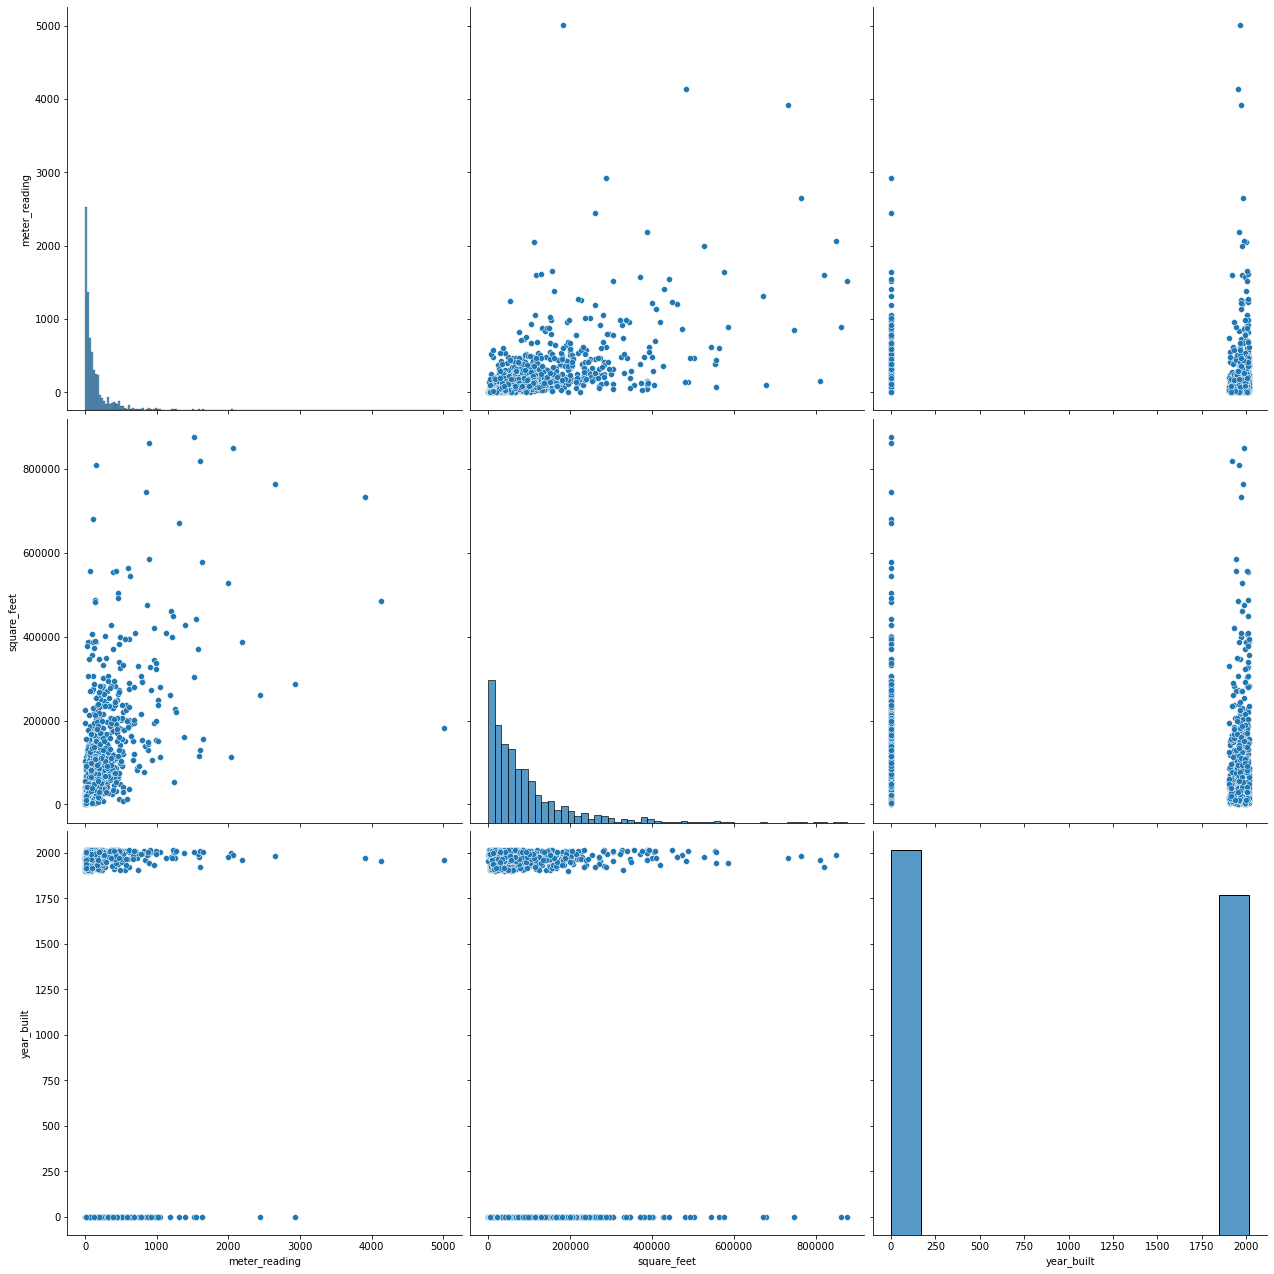

In [54]:
data_corr_meta = pd.DataFrame(energy.groupby("building_id").median(),columns=['meter_reading','square_feet','year_built'])

data_corr_meta.dropna(inplace=True)
sns.pairplot(data_corr_meta,height=6)
plt.show()
del data_corr_meta

In [55]:
data_corr_temp_primary = pd.DataFrame(energy,
                                      columns=['meter_reading','air_temperature','primary_use'])

data_corr_temp_primary.dropna(inplace=True)
sns.pairplot(data_corr_temp_primary,height=6,hue='primary_use')
plt.show()
del data_corr_temp_primary 

C:\anaconda\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\anaconda\lib\site-packages\seaborn\distributions.

Traceback (most recent call last):
  File "C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-404cb30d2342>", line 5, in <module>
    sns.pairplot(data_corr_temp_primary,height=6,hue='primary_use')
  File "C:\anaconda\lib\site-packages\seaborn\_decorators.py", line 46, in inner_f
    return f(**kwargs)
  File "C:\anaconda\lib\site-packages\seaborn\axisgrid.py", line 2045, in pairplot
    grid.add_legend()
  File "C:\anaconda\lib\site-packages\seaborn\axisgrid.py", line 142, in add_legend
    self.fig.draw(self.fig.canvas.get_renderer())
  File "C:\anaconda\lib\site-packages\matplotlib\artist.py", line 38, in draw_wrapper
    return draw(artist, renderer, *args, **kwargs)
  File "C:\anaconda\lib\site-packages\matplotlib\figure.py", line 1735, in draw
    mimage._draw_list_compositing_images(
  File "C:\anaconda\lib\site-packages\matplotlib\image.py", line 137, in _draw_li

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x000001D9F25DF3A0> (for post_execute):


KeyboardInterrupt: 